# Compare versions of AusEFlux (and OzWald GPP)




In [1]:
import os
import odc.geo
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import xr_rasterize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200453495808 due to system memory limit of 95.00 GiB
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configurati

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39711,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:36733,Total threads: 24
Dashboard: /proxy/44857/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:37961,


## Analysis Parameters

In [3]:
var = 'GPP'
version='v1.2'
base = f'/g/data/os22/chad_tmp/AusEFlux/'

### Open predictions

In [4]:
folder = base+f'results/AusEFlux/{var}/'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()

#combine annual files into one file
ds = xr.open_mfdataset(files)
ds = assign_crs(ds, crs='EPSG:4326')
ds.attrs['nodata'] = np.nan

## Open Bg Paper version

In [5]:
results_name= 'AusEFlux_'+var+'_2003_2022_5km_quantiles_v1.1.nc'
ds_v11 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name,
                      chunks = dict(time=1)
                      )
ds_v11 = assign_crs(ds_v11, crs='EPSG:4326')
ds_v11 = ds_v11.sel(time = slice('2003', '2021'))

## Convert to PgC/year

In [6]:
grid = ds.odc.geobox.to_crs('EPSG:3577')
ds_area = ds.odc.reproject(how=grid, resampling='bilinear').compute()

ds_v11_area = ds_v11.odc.reproject(how=grid, resampling='bilinear').compute()

/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [7]:
area_per_pixel = ds_area[var+'_median'].odc.geobox.resolution.x**2

if var != 'ET':
    ds_area = ds_area * area_per_pixel * 1e-15 * 12 # (pgC/year)
    ds_v11_area = ds_v11_area * area_per_pixel * 1e-15 * 12 # (pgC/year)
else:
    ds_area = ds_area * 12 # (mm/year)
    ds_v11_area = ds_v11_area * 12 # (mm/year)

## Zonal timeseries


### Annual bar graph

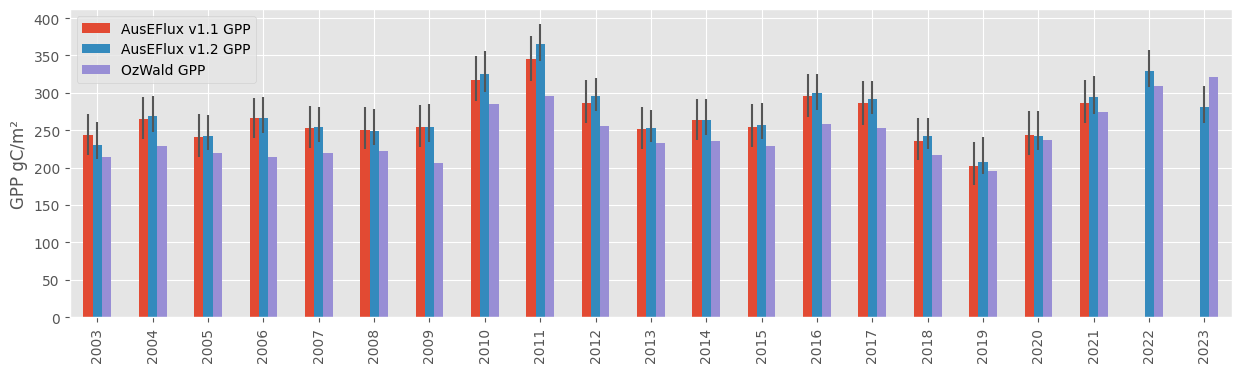

In [8]:
df = ds[var+'_median'].resample(time='1Y').sum().rename('AusEFlux v1.2 GPP').mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
df['lower_v12'] = ds[var+'_25th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
df['upper_v12'] = ds[var+'_75th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()

df['AusEFlux v1.1 GPP'] = ds_v11[var+'_median'].resample(time='1Y').sum().rename('AusEFlux v1.1 GPP').mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
df['lower_v11'] = ds_v11[var+'_25th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
df['upper_v11'] = ds_v11[var+'_75th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()

df.index = ds[var+'_median'].resample(time='1Y').sum().time.dt.year.values

if var =='GPP':
    df['OzWald GPP'] = pd.read_csv('/g/data/os22/chad_tmp/AusEFlux/data/National_Vegetation carbon uptake_annual.csv', index_col='Year').rename({'Value':'OzWald'},axis=1)

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1, figsize=(15,4))

    if var =='GPP':
        df[['AusEFlux v1.1 GPP', 'AusEFlux v1.2 GPP', 'OzWald GPP']].plot(ax=ax, kind='bar',
                        yerr={'AusEFlux v1.1 GPP': [df['AusEFlux v1.1 GPP'] - df['lower_v11'], df['upper_v11'] - df['AusEFlux v1.1 GPP']],
                              'AusEFlux v1.2 GPP': [df['AusEFlux v1.2 GPP'] - df['lower_v12'], df['upper_v12'] - df['AusEFlux v1.2 GPP']]
                             })
    else:
        df[['AusEFlux v1.1 GPP', 'AusEFlux v1.2 GPP']].plot(ax=ax, kind='bar',
                    yerr={'AusEFlux v1.1 GPP': [df['AusEFlux v1.1 GPP'] - df['lower_v11'], df['upper_v11'] - df['AusEFlux v1.1 GPP']],
                          'AusEFlux v1.2 GPP': [df['AusEFlux v1.2 GPP'] - df['lower_v12'], df['upper_v12'] - df['AusEFlux v1.2 GPP']]
                         })
    ax.set_ylabel(var+' gC/m\N{SUPERSCRIPT TWO}')
    plt.savefig(f'{base}results/figs/{var}_annual_barplot_ozwald_{version}.png', bbox_inches='tight', dpi=300)

## Ratio of OzWald to AusEFlux

In [16]:
df['OzWald / AusEFlux'] =  df['OzWald GPP'] / df['AusEFlux v1.2 GPP']

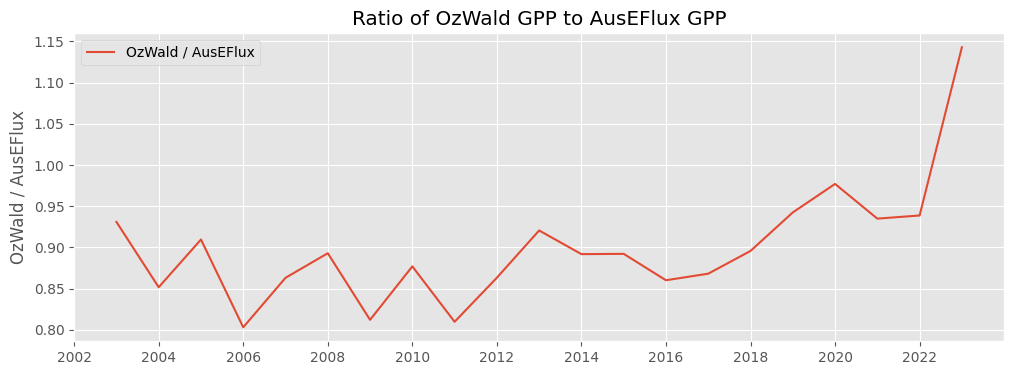

In [39]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    df[['OzWald / AusEFlux']].plot(ax=ax, kind='line')
    ax.set_title('Ratio of OzWald GPP to AusEFlux GPP')
    ax.set_ylabel('OzWald / AusEFlux')
    # ax.set_xlim(2003, 2023.5)
    ax.set_xticks(range(2002,2023, 2))
    ax.set_xticklabels(range(2002,2023, 2))
plt.savefig(f'{base}results/figs/{var}_ratio_with_ozwald_{version}.png', bbox_inches='tight', dpi=300)